In [1]:
import os
from pathlib import Path

import contextily as cx
import geopandas as gpd
import matplotlib.colors as mcol
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.axes import Axes
from PIL import Image, ImageColor

In [2]:
def get_image_from_colors(colors: np.ndarray) -> Image.Image:
    arr_stacked = np.stack(np.vectorize(ImageColor.getrgb)(colors), axis=2)
    return Image.fromarray(arr_stacked.astype("uint8"), "RGB")

In [3]:
data_path = Path(os.environ["DATA_PATH"])
generated_path = data_path / "generated"

ZONE = "02.2.03"
COLORS = np.array(
    [
        ["#f3f3f3", "#c2f1ce", "#8be2af"],
        ["#eac5dd", "#9ec6d3", "#7fc6b1"],
        ["#e6a3d0", "#bc9fce", "#7b8eaf"],
    ]
)
COLOR_IMAGE = get_image_from_colors(COLORS)

In [ ]:
def get_bivariate_colors(x: pd.Series, y: pd.Series) -> np.ndarray:
    cmap = mcol.BivarColormapFromImage(COLOR_IMAGE)

    norm_x = mcol.BoundaryNorm(
        [-np.inf, x.quantile(0.33), x.quantile(0.66), np.inf], cmap.N
    )
    norm_y = mcol.BoundaryNorm(
        [-np.inf, y.quantile(0.33), y.quantile(0.66), np.inf], cmap.N
    )
    normalized_vals = np.array([norm_y(y), norm_x(x)])
    return cmap(normalized_vals)


def add_bivariate_legend(
    ax: Axes,
    *,
    xpos: float = -0.02,
    ypos: float = 0.06,
    width: float = 0.3,
    height: float = 0.3,
    xlabel: str = "",
    ylabel: str = "",
) -> None:
    axin = ax.inset_axes([xpos, ypos, width, height])
    axin.imshow(COLOR_IMAGE, origin="lower")
    axin.set_xticks([])
    axin.set_yticks([])
    axin.set_xlabel(xlabel)
    axin.set_ylabel(ylabel)


def add_exact_bivariate_legend(
    ax: Axes,
    x: pd.Series,
    y: pd.Series,
    *,
    xpos: float = -0.02,
    ypos: float = 0.06,
    width: float = 0.3,
    height: float = 0.3,
    xlabel: str = "",
    ylabel: str = "",
) -> None:
    axin = ax.inset_axes([xpos, ypos, width, height])
    xticks = x.quantile([0, 0.33, 0.66, 1])
    yticks = y.quantile([0, 0.33, 0.66, 1])
    axin.imshow(COLOR_IMAGE, origin="lower", aspect="equal", interpolation="none")
    axin.set_xticks([-0.5, 0.5, 1.5, 2.5])
    axin.set_xticklabels([f"{v:.0f}" for v in xticks])
    axin.set_yticks([-0.5, 0.5, 1.5, 2.5])
    axin.set_yticklabels([f"{v:.0f}" for v in yticks])
    axin.set_xlabel(xlabel)
    axin.set_ylabel(ylabel)

In [56]:
df_jobs = (
    gpd.read_file(generated_path / "jobs" / "zone" / f"{ZONE}.gpkg")
    .set_index("codigo")
    .dropna(subset=["difference", "jobs"], how="any")
    .query("difference < 0")
    .assign(difference=lambda df: df["difference"].abs())
)

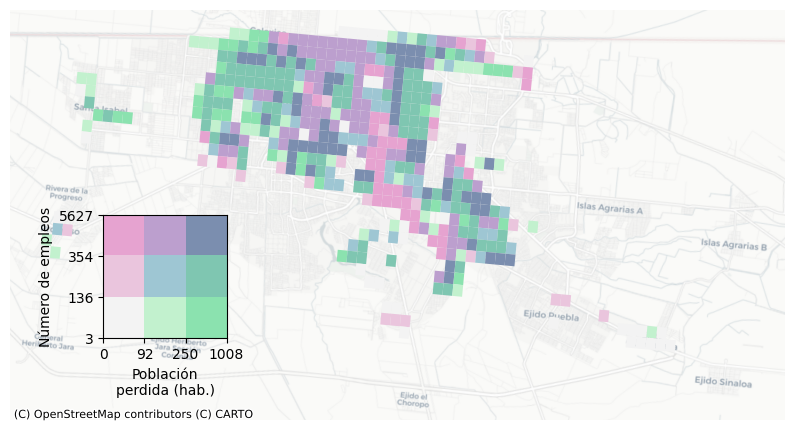

In [66]:
colors = get_bivariate_colors(x=df_jobs["difference"], y=df_jobs["jobs"])

fig, ax = plt.subplots(figsize=(10, 10))
df_jobs.plot(color=colors, ax=ax)
ax.set_xlim(1.215e6, 1.249e6)
ax.set_ylim(2.332e6, 2.35e6)
# add_bivariate_legend(
#     ax, xlabel="Más pérdida de ⟶\npoblación", ylabel="Más empleos ⟶", ypos=0.2
# )
add_exact_bivariate_legend(
    ax,
    x=df_jobs["difference"],
    y=df_jobs["jobs"],
    xpos=0.05,
    ypos=0.2,
    xlabel="Población\nperdida (hab.)",
    ylabel="Número de empleos",
)
cx.add_basemap(ax, crs=df_jobs.crs, source=cx.providers.CartoDB.Positron, zoom=12)
ax.axis("off")
fig.savefig("./fixed.jpg", dpi=300, bbox_inches="tight")